In [17]:
import os
import numpy as np
import scipy as sp
from functools import partial
from collections import namedtuple
from scipy import misc as spm
from scipy.io import loadmat
from skimage.transform import resize
from scipy.spatial.distance import euclidean
from scipy import interpolate as spi
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from skimage import img_as_float

from skimage import transform as skitr

# turn of numpy warnings for now..
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Exercise: Image Transformations

## Problem Statement

Perform a comparative analysis of standard image interpolation techniques for different image processing tasks.

### Task 1 - Error Concealment using Image Interpolation

Given in the data/image_transformations_assignment.mat file are input images (ImInput) and erroneous pixel mask (ErrorMask) where imaging errors were observed. These are given as Matlab MAT file, that can be loaded using the scipy.io.loadmat function, which returns a dictionary that contains all the needed data. 

Perform image interpolation at the erroneous pixels using only the non-erroneous pixels surrounding them and generate image ImErrorConcealed. 

Compare the error-concealed image ImErrorConcealed with ground truth image (ImGroundTruth) to compare the performance of your inter- polation technique.

_Interpolation Techniques to Explore_: Linear Interpolation 

_Functions to use_: Write your own linear interpolation function.

In [18]:
assignment_data = loadmat(os.path.join("data", "image_transformations_assignment.mat"))
assignment_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ImInput', 'ErrorMask', 'ImErrorConcealed', 'ImGroundTruth', 'ImOrig', 'Scales', 'ImRescaled', 'ImForward', 'ImInverse'])

In [19]:
ImInput = assignment_data["ImInput"]
ImOrig = assignment_data["ImOrig"]
ErrorMask = assignment_data["ErrorMask"]
ImGroundTruth = assignment_data["ImGroundTruth"]
Scales = assignment_data["Scales"][0]

(-0.5, 511.5, 511.5, -0.5)

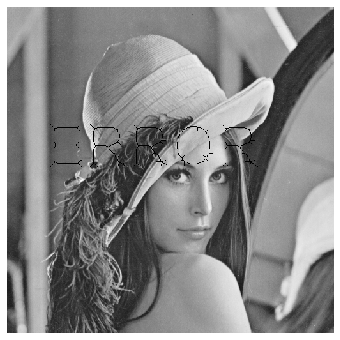

In [20]:
plt.figure(figsize=(6,6))
plt.imshow(ImInput, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

(512, 512)

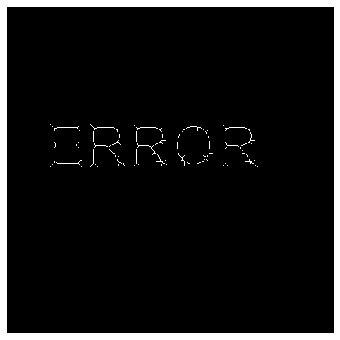

In [21]:
plt.figure(figsize=(6,6))
plt.imshow(ErrorMask, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
ErrorMask.shape

In [22]:
def get4ngb(rows, cols, x, y):
    # function ngb = get4ngb(rows, cols, x, y)
    # 
    # Input:
    # rows, cols    Number of rows and colums from the 2D Image
    # x,y           Coordinates of the center point
    #
    # Output:
    # ngb           list of possible neighbours

    # initialize empty result list
    ngb = list()

    # east
    if x > 1:
        ngb += [[x-1, y]];

    # north
    if y < cols-1:
        ngb += [[x, y+1]];

    # west
    if x < rows-1:
        ngb += [[x+1, y]];

    # south
    if y > 1:
        ngb += [[x, y-1]];

    return ngb 

In [23]:
ImErrorConcealed = np.zeros(ImInput.shape, dtype=ImInput.dtype)

h, w = ImInput.shape
for y in range(h):
    for x in range(w):
        # if pixel is ok, then just store it
        if ErrorMask[y,x] == 0:
            ImErrorConcealed[y,x] = ImInput[y,x]
        else:
            # look up neighboring pixel coordinates
            points = get4ngb(w, h, x, y)
            # search for pixels that are not in error mask and are within the image boundaries
            v = 0.
            c = 0
            for p in points:
                if ErrorMask[p[1], p[0]] == 1:
                    continue
                v += ImInput[p[1], p[0]]
                c += 1
            # since all distances are equal (we always use array-indices), 
            # we can just divide by the number of samples we used to recreate the missing pixel
            if c > 0:
                v /= c
            ImErrorConcealed[y,x] = v

(-0.5, 511.5, 511.5, -0.5)

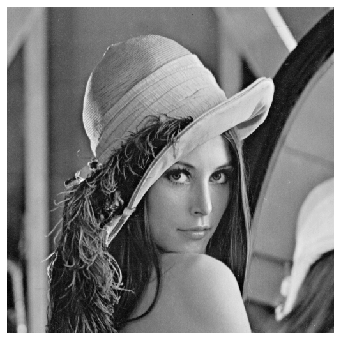

In [24]:
plt.figure(figsize=(6,6))
plt.imshow(ImErrorConcealed, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

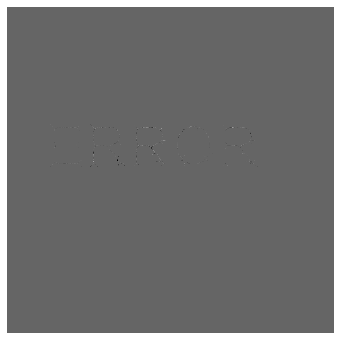

In [43]:
plt.figure(figsize=(6,6))
plt.imshow(ImErrorConcealed - ImGroundTruth, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

### Task 2 - Interpolation for Image Resizing

Given in the AssignmentData.mat file are input images (ImOrig) and a set of geometric scale factors Scales. Isotropically scale ImOrig using these scale factors and inverse the scaling operation to bring back the image to the original scale. Lets call this ImRescaled. Perform this rescaling using different interpolation techniques. Compare the rescaled image ImRescaled to the original image ImOrig to understand reconstruction error that the interpolation technique results in.

Interpolation Kernels to Explore: Nearest Neighbor, Bilinear, Bicubic, Lanczoz.

Functions to use: Write your own nearest and bilinear interpolation functions. For the rest, you can use the function we defined here

In [26]:
def resizeBicubic(image, scalingFactor):
    im = Image.fromarray(image)
    (width, height) = (image.shape[0] * scalingFactor, image.shape[1] * scalingFactor)
    im_resized = im.resize((int(width), int(height)), resample=PIL.Image.BICUBIC)
    return np.asarray(im_resized)

def resizeLanczos(image, scalingFactor):
    im = Image.fromarray(image)
    (width, height) = (image.shape[0] * scalingFactor, image.shape[1] * scalingFactor)
    im_resized = im.resize((int(width), int(height)), resample=PIL.Image.LANCZOS)
    return np.asarray(im_resized)

In [27]:
def vec(*args):
    return np.array(args)

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [28]:
def nearest_neighbor_coord(img, y, x):
    # compute nearest neighbor by rounding to 0 decimals
    h_ = np.round(y)
    w_ = np.round(x)
    
    # sanity checks of result (what if h,w is below 0 or larger than the image?)
    h_max, w_max = img.shape
    h_ = np.clip(h_, 0, h_max-1)
    w_ = np.clip(w_, 0, w_max-1)

    # return coordinates
    return vec(int(h_), int(w_))

def nearest_neighbor(img, y, x):
    p = nearest_neighbor_coord(img, y, x)
    # lookup value for computed coordinate
    return img[p[0],p[1]]


In [29]:
def closest_coords_2x2(img, y, x):
    # compute surrounding 2x2 neighbors
    h1 = np.floor(y)
    w1 = np.floor(x)
    h2 = np.ceil(y)
    w2 = np.ceil(x)
    
    # direct hit, no interpolation necessary
    if h1 == h2 and w1 == w2:
        return vec(int(y), int(x)), None, None, None
    
    # sanity checks of result (what if x,y is below 0 or larger than the image?)
    h_max, w_max = img.shape
    h1 = np.clip(h1, 0, h_max - 1)
    w1 = np.clip(w1, 0, w_max - 1)
    h2 = np.clip(h2, 0, h_max - 1)
    w2 = np.clip(w2, 0, w_max - 1)

    # surrounding points
    sw = vec(int(h2), int(w1))
    se = vec(int(h2), int(w2))
    nw = vec(int(h1), int(w1))
    ne = vec(int(h1), int(w2))
    
    #print vec(x,y), sw, se, nw, ne
    return sw, se, nw, ne


def bilinear_interpolation(img, y, x):
    sw, se, nw, ne = closest_coords_2x2(img, y, x)
    if se is None:
        if np.all(sw == vec(y,x)):
            return img[sw[0],sw[1]]
        else:
            return 0.
    
    origin = sw
    hs = np.abs(y - origin[0])
    ws = np.abs(x - origin[1])

    # calculation as shown in slide 46
    s = img[sw[0],sw[1]] * (1 - ws) + img[se[0],se[1]] * ws
    n = img[nw[0],nw[1]] * (1 - ws) + img[ne[0],ne[1]] * ws
    v = s * (1 - hs) + n * hs
    return np.clip(v, 0, 255.)

In [30]:
def mk_scale_matrix(sx, sy):
    return np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]], dtype=np.float)

def mk_translate_matrix(tx, ty):
    return np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]], dtype=np.float)

def mk_rotate_matrix(a):
    return np.array([[np.cos(a), -np.sin(a), 0], [np.sin(a), np.cos(a), 0], [0, 0, 1]], dtype=np.float)


In [31]:
def fwarp(src, dst, tf, kernel, offset=None):
    h, w = src.shape
    oy, ox = offset if offset is not None else [0,0]
    for y in range(h):
        for x in range(w):
            cx, cy = (tf.dot(vec(x, y, 1)))[:2]
            kernel(dst, cy-oy, cx-ox, src[y,x])
    

def iwarp(src, dst, tf, kernel, offset=None):
    h, w = dst.shape
    sh, sw = src.shape
    oy, ox = offset if offset is not None else [0,0]
    tf_inv = np.linalg.inv(tf)
    for y in range(h):
        y = y + oy
        for x in range(w):
            x = x + ox
            cx, cy = (tf_inv.dot(vec(x, y, 1)))[:2]
            # don't fill if source is outside of image
            if cx == np.clip( cx, 0, sw - 1 ) and cy == np.clip( cy, 0, sh - 1 ):
                dst[int(y-oy), int(x-ox)] = kernel(src, cy, cx)



helper to compute target image size

In [32]:
height, width = ImOrig.shape
grid_h, grid_w = np.meshgrid(range(height), range(width))

select which method / scaling-factor should be used

In [44]:
interp_func = nearest_neighbor
# interp_func = bilinear_interpolation
# ScaleFactorIdx = 0
# ScaleFactorIdx = 1
# ScaleFactorIdx = 2
# ScaleFactorIdx = 3
ScaleFactorIdx = 4
# ScaleFactorIdx = 5

In [45]:
Mscale = mk_scale_matrix(Scales[ScaleFactorIdx], Scales[ScaleFactorIdx])
M = Mscale
M

array([[4., 0., 0.],
       [0., 4., 0.],
       [0., 0., 1.]])

Compute the new image size

In [35]:
pixels = np.array([grid_h, grid_w]).T
all_pixels = pixels.reshape(-1, pixels.shape[-1])

proj_coordinates = np.zeros(all_pixels.shape, dtype=np.float)
for i, p in enumerate(all_pixels):
    proj_coordinates[i] = M.dot(vec(p[1], p[0], 1))[:2]
    
val_max = np.ceil(np.max(proj_coordinates, axis=0)).astype(np.int)
val_min = np.floor(np.min(proj_coordinates, axis=0)).astype(np.int)

dimensions_result = ((val_max - val_min).astype(np.int) + 1).tolist()
dimensions_result.reverse()

origin_offset = val_min.tolist()
origin_offset.reverse()
print ("val_min: ", val_min)
print ("val_max: ", val_max)
print ("dimensions: ", dimensions_result)
print ("offset: ", origin_offset)

val_min:  [0 0]
val_max:  [508 508]
dimensions:  [509, 509]
offset:  [0, 0]


Scale the image

In [36]:
src_image = ImOrig
iwrapped_image = np.zeros(dimensions_result, dtype=np.float)

In [37]:
iwarp(src_image, iwrapped_image, M, interp_func, offset=origin_offset)

(-0.5, 508.5, 508.5, -0.5)

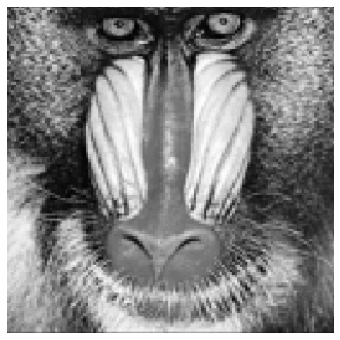

In [38]:
plt.figure(figsize=(6,6))
plt.imshow(iwrapped_image, cmap=plt.cm.gray)
plt.axis('off')

In [39]:
undo_scale_image = np.zeros(ImOrig.shape, dtype=ImOrig.dtype)
iwarp(iwrapped_image, undo_scale_image, np.linalg.inv(M), interp_func, offset=origin_offset)

(-0.5, 127.5, 127.5, -0.5)

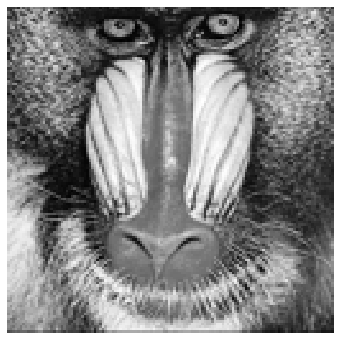

In [40]:
plt.figure(figsize=(6,6))
plt.imshow(undo_scale_image, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

example using Bicubic or Lanczos

(-0.5, 511.5, 511.5, -0.5)

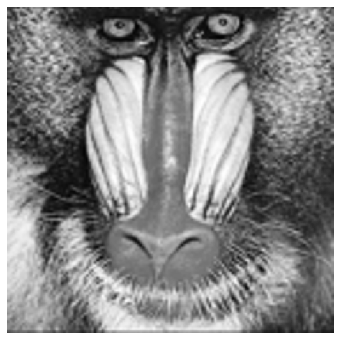

In [42]:
plt.figure(figsize=(6,6))
plt.imshow(resizeBicubic(src_image, ScaleFactorIdx), cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

## Task 3 - Defining and applying simple geometric transformations

Compose the transformation matrix for the following transformations (Order: Scale, Rotate about Origin and Translate) using the composition procedure in Slide 33 of the lecture slides.

 1. Scale non-uniformly in by a factor of 0.5 for x-direction and 2.0 for y-direction. 
 2. Rotate clockwise by 45 degrees about the origin.
 3. Translate by 10 pixels in x-direction and −10 pixels in the y-direction

Apply this transformation to ImOrig given in the AssignmentData.mat file, using Forward Warping with nearest-neighbor splatting. Lets call this image ImForward. (Psuedo-code in Slide 32)

Apply this transformation to ImOrig using Inverse Warping with nearest-neighbor interpolation. Lets call this image ImInverse. (Psuedo-code in Slide 35)

Comparing with in-built functions: Apply this transformation on image ImOrig and display transformed image (say ImTransformed). Get the inverse of this transform and apply on ImTransformed to reverse the transformation.

Functions to use: meshgrid(if necessary) 

For comparison: look at functions provided from skimage.transform

In [5]:
Mscale = mk_scale_matrix(0.5, 2.)
Mrotate = mk_rotate_matrix(np.deg2rad(45))
Mtranslate = mk_translate_matrix(10, -10)
M = Mtranslate.dot(Mscale.dot(Mrotate))


NameError: name 'mk_scale_matrix' is not defined

In [3]:
pixels = np.array([grid_h, grid_w]).T
all_pixels = pixels.reshape(-1, pixels.shape[-1])

NameError: name 'np' is not defined

In [4]:
proj_coordinates = np.zeros(all_pixels.shape, dtype=np.float)
for i, p in enumerate(all_pixels):
    proj_coordinates[i] = M.dot(vec(p[1], p[0], 1))[:2]

NameError: name 'np' is not defined

In [ ]:
val_max = np.ceil(np.max(proj_coordinates, axis=0)).astype(np.int)
val_min = np.floor(np.min(proj_coordinates, axis=0)).astype(np.int)

dimensions_result = ((val_max - val_min).astype(np.int) + 1).tolist()
dimensions_result.reverse()

origin_offset = val_min.tolist()
origin_offset.reverse()
print ("val_min: ", val_min)
print ("val_max: ", val_max)
print ("dimensions: ", dimensions_result)
print ("offset: ", origin_offset)

In [ ]:
def nn_splatting(img, y, x, value):
    sw, se, nw, ne = closest_coords_2x2(img, y, x)
    # direct hit or out-of-bounds
    if se is None:
        if np.all(sw == vec(y,x)):
            img[sw[0],sw[1]] = value
        else:
            img[sw[0],sw[1]] = 0.
    
    for c in [sw, se, nw, ne]:
        if c is not None:
            img[c[0],c[1]] = value

In [ ]:
src_image = ImOrig
ImForward = np.zeros(dimensions_result, dtype=ImOrig.dtype)

In [ ]:
fwarp(src_image, ImForward, M, nn_splatting, offset=origin_offset)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(ImForward, cmap=plt.cm.gray)
plt.axis('off')

In [ ]:
ImInverse = np.zeros(dimensions_result, dtype=ImOrig.dtype)

In [ ]:
iwarp(src_image, ImInverse, M, bilinear_interpolation, offset=origin_offset)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(ImInverse, cmap=plt.cm.gray)
plt.axis('off')

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(np.abs(ImInverse-ImForward), cmap=plt.cm.gray)
plt.axis('off')

Try out skimage.transform methods

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(skitr.warp(ImOrig, M), cmap=plt.cm.gray)
plt.axis('off')